In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC

from Pélec_04_fonctions import visuPCA

write_data = True

In [2]:
BEB = pd.read_csv('BEB.csv')

BEBM = BEB.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
SiteEnergyUse = np.array(BEB['SiteEnergyUse(kBtu)']).reshape(-1, 1)
TotalGHGEmissions = np.array(BEB.TotalGHGEmissions).reshape(-1, 1)

BEBM_train, BEBM_test, SiteEnergyUse_train, SiteEnergyUse_test = train_test_split(
    BEBM, SiteEnergyUse, test_size=.2)


In [3]:
# Scaler moins sensible aux outlier d'après la doc
scaler = RobustScaler()


In [4]:
# ACP sur toutes les colonnes
numPCA = BEB.select_dtypes('number').drop(columns='DataYear').dropna().values
RobPCA = make_pipeline(StandardScaler(), PCA())
components = RobPCA.fit_transform(numPCA)
pca = RobPCA.named_steps['pca']
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


In [5]:
# visualisation de la variance expliquée de chaque composante (cumulée)
exp_var_cum = np.cumsum(pca.explained_variance_ratio_)
fig = px.area(x=range(1, exp_var_cum.shape[0] + 1),
              y=exp_var_cum,
              labels={
                  'x': 'Composantes',
                  'y': 'Variance expliquée cumulée'
              })
fig.update_layout(title='Scree plot')
fig.show()
if write_data is True:
    fig.write_image('./Figures/ScreePlot.pdf', height=300)


In [6]:
# création des graphiques
for a1, a2 in [[0,1],[0,2],[0,3], [0,4],[1,2],[1,3], [1,4], [2,3], [2,4]]:
    fig = visuPCA(BEB.select_dtypes('number').drop(columns='DataYear').dropna(),
              pca,
              components,
              loadings, [(a1, a2)],
              color=BEB.select_dtypes('number').drop(columns='DataYear').dropna()['SiteEnergyUse(kBtu)'])
    fig.show('browser')
    if write_data is True:
        fig.write_image('./Figures/PCAF{}F{}.pdf'.format(a1+1, a2+1), width=1100, height=1100)


In [7]:
# modèle régression linéaire
pipeLR = make_pipeline(scaler, linear_model.LinearRegression())

pipeLR.fit(BEBM_train, SiteEnergyUse_train)

SiteEnergyUse_pred = pipeLR.predict(BEBM_test)

LRr2 = metrics.r2_score(SiteEnergyUse_test, SiteEnergyUse_pred)
print("r2 :", LRr2)
LRrmse = metrics.mean_squared_error(SiteEnergyUse_test, SiteEnergyUse_pred)
print("rmse :", LRrmse)

# modèle kNN
pipekNN = make_pipeline(scaler, KNeighborsRegressor(n_jobs=-1))

# Fixer les valeurs des hyperparamètres à tester
param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}

# optimisation score
score = ['r2', 'neg_root_mean_squared_error']

# Classifieur kNN avec recherche d'hyperparamètre par validation croisée
gridpipekNN = GridSearchCV(
    pipekNN,  # un classifieur kNN
    param_grid,  # hyperparamètres à tester
    cv=5,  # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

# Optimisation du classifieur sur le jeu d'entraînement
gridpipekNN.fit(BEBM_train, SiteEnergyUse_train)


r2 : 0.601243163639134
rmse : 119211253760423.36


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11,
                                                              13, 15, 17, 19,
                                                              21]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_root_mean_squared_error'])

In [8]:
# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
best_parameters = gridpipekNN.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
	kneighborsregressor__n_neighbors: 3


In [9]:
# Afficher les performances correspondantes
print("Résultats R² de la validation croisée :")
for mean, std, params in zip(
        gridpipekNN.cv_results_['mean_test_r2'],  # score moyen
        gridpipekNN.cv_results_['std_test_r2'],  # écart-type du score
        gridpipekNN.cv_results_['params']  # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score[0], mean, std, params))

# Afficher les performances correspondantes
print("Résultats RMSE de la validation croisée :")
for meanrmse, stdrmse, params in zip(
        -(gridpipekNN.cv_results_['mean_test_neg_root_mean_squared_error']),  # score moyen
        gridpipekNN.cv_results_['std_test_neg_root_mean_squared_error'],  # écart-type du score
        gridpipekNN.cv_results_['params']  # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score[1], mean, std, params))


Résultats R² de la validation croisée :
r2 = 0.379 (+/-0.079) for {'kneighborsregressor__n_neighbors': 3}
r2 = 0.336 (+/-0.125) for {'kneighborsregressor__n_neighbors': 5}
r2 = 0.328 (+/-0.137) for {'kneighborsregressor__n_neighbors': 7}
r2 = 0.316 (+/-0.140) for {'kneighborsregressor__n_neighbors': 9}
r2 = 0.327 (+/-0.124) for {'kneighborsregressor__n_neighbors': 11}
r2 = 0.332 (+/-0.133) for {'kneighborsregressor__n_neighbors': 13}
r2 = 0.341 (+/-0.133) for {'kneighborsregressor__n_neighbors': 15}
r2 = 0.343 (+/-0.133) for {'kneighborsregressor__n_neighbors': 17}
r2 = 0.347 (+/-0.127) for {'kneighborsregressor__n_neighbors': 19}
r2 = 0.346 (+/-0.118) for {'kneighborsregressor__n_neighbors': 21}
Résultats RMSE de la validation croisée :
neg_root_mean_squared_error = 0.346 (+/-0.118) for {'kneighborsregressor__n_neighbors': 3}
neg_root_mean_squared_error = 0.346 (+/-0.118) for {'kneighborsregressor__n_neighbors': 5}
neg_root_mean_squared_error = 0.346 (+/-0.118) for {'kneighborsregress

In [22]:
#modèle Rige
piperige = make_pipeline(scaler, linear_model.Ridge())

alphas = np.logspace(0, 5, 1000)
param_grid = {'ridge__alpha': alphas}


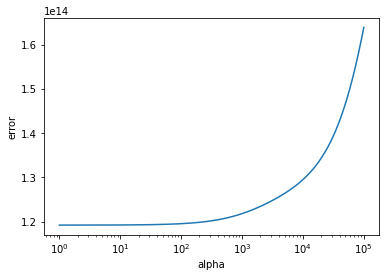

In [23]:
errors = []
for a in alphas:
    piperige.set_params(ridge__alpha=a)
    piperige.fit(BEBM_train, SiteEnergyUse_train)
    errors.append(
        np.mean((piperige.predict(BEBM_test) - SiteEnergyUse_test)**2))
# graph rmse
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()


In [12]:
# Validation croisée
gridpiperige = GridSearchCV(piperige,
                            param_grid,
                            cv=5,
                            scoring=score,
                            refit='neg_root_mean_squared_error',
                            n_jobs=-1)

gridpiperige.fit(BEBM_train, SiteEnergyUse_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('ridge', Ridge(alpha=100000.0))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([   100.        ,    103.53218433,    107.18913192,    110.97524964,
          114.89510002,    118.95340674,    123.15506033,    127.50512407,
          132.00884008,    136.67163565,    141.49912974,    146.49713983,
          151.67168885,    157.02901247,    162.57556664,    168.31803...
        51709.20242897,  53535.66677411,  55426.64520663,  57384.41648302,
        59411.33984965,  61509.85788581,  63682.49944719,  65931.88271334,
        68260.71834272,  70671.81273927,  73168.07143427,  75752.50258772,
        78428.22061338,  81198.44993184,  84066.52885618,  87035.91361485,
        90110.18251665,  93293.04026285,  96588.32241159, 100000.        ])},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_root_mea

In [13]:
# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
best_parameters = gridpiperige.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
	ridge__alpha: 1783.4308769319093


In [14]:
# Afficher les performances correspondantes
print("Résultats pour R² de la validation croisée :")
for meanr2, stdr2, params in zip(
        gridpiperige.cv_results_['mean_test_r2'],  # score moyen
        gridpiperige.cv_results_['std_test_r2'],  # écart-type du score
        gridpiperige.cv_results_['params']  # valeur de l'hyperparamètre
):

    print("{} = {:.5f} (+/-{:.05f}) for {}".format(score[0], mean, std, params))

print("Résultats pour RMSE de la validation croisée :")
for meanrmse, stdrmse, params in zip(
        -(gridpiperige.cv_results_['mean_test_neg_root_mean_squared_error']),  # score moyen
        gridpiperige.cv_results_['std_test_neg_root_mean_squared_error'],  # écart-type du score
        gridpiperige.cv_results_['params']  # valeur de l'hyperparamètre
):

    print("{} = {:.5f} (+/-{:.05f}) for {}".format(score[1], mean, std, params))


Résultats pour R² de la validation croisée :
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 100.0}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 103.53218432956626}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 107.18913192051275}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 110.97524964120721}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 114.89510001873086}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 118.95340673703195}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 123.15506032928262}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 127.50512407130128}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 132.00884008314182}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 136.6716356462006}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 141.4991297434576}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 146.49713983072863}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 151.67168884709224}
r2 = 0.34610 (+/-0.11817) for {'ridge__alpha': 157.02901247293775}
r2 = 0.34610 (+/-0.11817) for {'

In [15]:
# Prédiction y
SiteEnergyUse_pred = gridpiperige.predict(BEBM_test)

# Calcul RMSE
rmse = metrics.mean_squared_error(SiteEnergyUse_test,
                                  SiteEnergyUse_pred,
                                  squared=False)
print('rmse :', rmse)


rmse : 11096744.639569374


In [28]:
# modèle elastic net
pipeEN = make_pipeline(scaler, linear_model.ElasticNet())

alphas = np.logspace(-5, 5, 1000)
param_grid = {'elasticnet__alpha': alphas}


/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.022e+17, tolerance: 1.795e+14

/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.022e+17, tolerance: 1.795e+14

/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

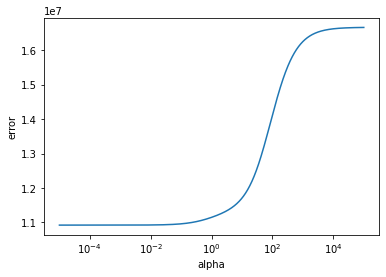

In [29]:
errors = []
for a in alphas:
    pipeEN.set_params(elasticnet__alpha=a)
    pipeEN.fit(BEBM_train, SiteEnergyUse_train)
    errors.append(
        metrics.mean_squared_error(SiteEnergyUse_test,
                                   pipeEN.predict(BEBM_test),
                                   squared=False))

# graph rmse
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()


In [18]:
# Validation croisée
gridpipeEN = GridSearchCV(pipeEN,
                          param_grid,
                          cv=5,
                          scoring=score,
                          refit='neg_root_mean_squared_error',
                          n_jobs=-1)

gridpipeEN.fit(BEBM_train, SiteEnergyUse_train)


/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+17, tolerance: 8.331e+13
  model = cd_fast.enet_coordinate_descent(
/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.141e+17, tolerance: 1.474e+14
  model = cd_fast.enet_coordinate_descent(
/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the nu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': array([1.00000000e-05, 1.01159111e-05, 1.02331658e-05, 1.03517796e-05,
       1.04717682e-05, 1.05931476e-05, 1.07159340e-05, 1.08401436e-05,
       1.09657929e-05, 1.10928986e-05, 1.12214777e-05, 1.13515471e-05,
       1.14831241e-05,...
       8.03350198e-01, 8.12661920e-01, 8.22081576e-01, 8.31610415e-01,
       8.41249705e-01, 8.51000725e-01, 8.60864770e-01, 8.70843150e-01,
       8.80937190e-01, 8.91148232e-01, 9.01477631e-01, 9.11926760e-01,
       9.22497005e-01, 9.33189772e-01, 9.44006479e-01, 9.54948564e-01,
       9.66017480e-01, 9.77214697e-01, 9.88541702e-01, 1.00000000e+00])},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_root_mean_squared_error'])

In [19]:
# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
best_parameters = gridpipeEN.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
	elasticnet__alpha: 0.8412497049736118


In [20]:
# Afficher les performances correspondantes
print("Résultats pour R² de la validation croisée :")
for meanr2, stdr2, params in zip(
        gridpipeEN.cv_results_['mean_test_r2'],  # score moyen
        gridpipeEN.cv_results_['std_test_r2'],  # écart-type du score
        gridpipeEN.cv_results_['params']  # valeur de l'hyperparamètre
):

    print("{} = {:.5f} (+/-{:.05f}) for {}".format(score[0], meanr2, stdr2,
                                                   params))

print("Résultats pour RMSE de la validation croisée :")
for meanrmse, stdrmse, params in zip(
        -(gridpipeEN.cv_results_['mean_test_neg_root_mean_squared_error']
          ),  # score moyen
        gridpipeEN.cv_results_[
            'std_test_neg_root_mean_squared_error'],  # écart-type du score
        gridpipeEN.cv_results_['params']  # valeur de l'hyperparamètre
):

    print("{} = {:.5f} (+/-{:.05f}) for {}".format(score[1], meanrmse, stdrmse,
                                                   params))


Résultats pour R² de la validation croisée :
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.0115911122238297e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.0233165783302449e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.0351779556301762e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.0471768194855202e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.05931476351837e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.0715933998226711e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.084014359178331e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.09657929126781e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.1092898648952227e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.1221477682079803e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.1351547089209991e-05}
r2 = 0.50684 (+/-0.17466) for {'elasticnet__alpha': 1.14831241454

In [21]:
# Prédiction y
SiteEnergyUse_pred = gridpipeEN.predict(BEBM_test)

# Calcul RMSE
rmse = metrics.mean_squared_error(SiteEnergyUse_test,
                                  SiteEnergyUse_pred,
                                  squared=False)
print('rmse :', rmse)



rmse : 11122360.220477195
